In [1]:
# !pip install openpyxl            #to read .xlsx format files
import numpy as np
import pandas as pd
import time
import math
from random import randint
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#=============================== Let's get data information =================================================

def dataset_info():
    '''this function reads the information about all datas
       and returns informations as a pandas table BKS'''
    
    #readin excel format file with pandas
    BKS =  pd.read_excel('BKS.xlsx', sheet_name='BKS')
    
    #rename the features
    BKS.rename(columns={'Ins':'file_name', 'n':'Nom_of_node', 'K':'K_min', 'Q':'veh_cap'}, inplace=True)
    
    # Add '.txt' to file_name values
    for i in range(30):
        BKS.loc[i,'file_name'] = BKS.loc[i,'file_name']+str('.txt')
    return BKS

In [3]:
#================================ reading all text files ========================================================

def get_files(info):
    ''' This function reads all text files and pass them to a dictionary'''
    
    # Reading each file.txt as a table an save all them in a dictionary
    File_Name_dic = {}
    rows= info.index.tolist()
    for row in rows:
        File_Name_dic['data'+str(row)] = pd.read_table(info.loc[row, 'file_name'])
    return rows, File_Name_dic

In [4]:
# ======================== Extracting Tables from each File ====================================================

def get_table(BKS, File_Name_dic,rows):
    ''' Extracts tables from text files and saves them as dictionaries'''
    
    Locations={}
    Demands = {}
    
    # defining some parameters for slicing 
    L_N = 6+BKS['Nom_of_node']
    D_N_L = L_N+2
    D_N_U = D_N_L + BKS['Nom_of_node']
    
    # reading cotumers' location and costumers' demand from each file
    for row in rows:
         Locations['loc'+str(row)] = File_Name_dic['data'+str(row)].loc[6:L_N[row]]
        col2 = str(Locations['loc'+str(row)].columns[1])
        Locations['loc'+str(row)].rename(columns={'NAME : ':'ind',col2:'x','Unnamed: 2':'y'}, inplace=True)
        Locations['loc'+str(row)].set_index('ind', inplace=True)
    
        Demands['dem'+str(row)] = File_Name_dic['data'+str(row)].loc[D_N_L[row]:D_N_U[row]]
        Demands['dem'+str(row)].rename(columns={'NAME : ':'ind',col2:'d'}, inplace=True)
        Demands['dem'+str(row)].set_index('ind', inplace=True)
        Demands['dem'+str(row)].drop('Unnamed: 2',axis=1, inplace=True)
    return Locations, Demands

In [5]:
def coordinates(df, BKS):
    '''return coordinates all points'''
    depo = df.iloc[0,:]
    x_d, y_d = depo[0], depo[1]
    x_c, y_c = df['x'][1:], df['y'][1:]
    return x_d, y_d, x_c, y_c

In [6]:
def initial_solution(cust_list, n, d, Q, dist ):
    
#====================================first method (Randon) =========================================================    
#     Initial_Route = {}   
#     is_visited = [False for i in range(n)]
#     random.shuffle(cust_list)
#     j=0
#     # for each customer checks the capacity feasibility of a route and assigns it
#     while sum(is_visited)!=n:
#         u = 0
#         Initial_Route[j] = [0]
#         for i in cust_list :
#             if is_visited[i-1]==False:
#                 if u+d[i] <= Q:
#                     Initial_Route[j].append(i)
#                     is_visited[i-1]=True
#                     u = u+d[i]  
#         j+=1
#     return Initial_Route
#====================================second method (Heuristic 1)===================================================

#     Initial_Rout = {}
#     H = [a for a in range(n+1)]
#     coord_h = [(a,b) for a in H for b in H if a!=b]
#     Y = {(a,b):dist[(a,b)] for a,b in coord_h}
#     all_checked = [False for a in range(1, n+1)]

#     a = 0
#     j = 0
#     u = 0
#     Initial_Rout[j] = [0]
#     node_visited_init = [0]
#     while sum(all_checked)!= n:
    
#         min_dist = 10000
#         for b in H:
#             if b!=a:
#                 if b not in node_visited_init:
                
#                     if Y[(a,b)] < min_dist:
#                         min_dist = Y[(a,b)]
#                         visit = b
#         node_visited_init.append(visit)
#         if all_checked[visit-1]==False:
#             if u+d[visit] <= Q:
#                 Initial_Rout[j].append(visit)
#                 all_checked[visit-1]=True
#                 u = u+d[visit]
#                 a = visit
#             else:
#                 j+=1
#                 u = 0
#                 Initial_Rout[j] = [0]
#                 if u+d[visit] <= Q:
#                     Initial_Rout[j].append(visit)
#                     all_checked[visit-1]=True
#                     u = u+d[visit]
#                     a = visit

#     return Initial_Rout
#====================================Third method (heuristic 2) ===================================================
    Initial_Rout={}
    H = [a for a in range(n+1)]
    coord_h = [(a,b) for a in H for b in H if a!=b]
    Y = {(a,b):dist[(a,b)] for a,b in coord_h}
    all_checked = [False for a in range(1, n+1)]
    j = 0
    Initial_Rout[j] = [0]
    node_visited_init = [0]
    r = random.sample(H, 1)[0]
    Initial_Rout[j].append(r)
    node_visited_init.append(r)
    all_checked[r-1] = True
    while sum(all_checked)!= n:
        a = Initial_Rout[j][-1]
        my_list = {}
        for b in H:
            if b not in node_visited_init:
                if b!=a:
                    my_list[b]=Y[(a,b)]
        my_list_as = {k: v for k, v in sorted(my_list.items(), key=lambda item: item[1])}
        my_list_key = list(my_list_as.keys())
        my_list_value = list(my_list_as.values())
        i = 0
        node_ass = False
        rout_deman = [d[a] for a in Initial_Rout[j]]
        u = np.sum(rout_deman)
        while node_ass == False:
            visit = my_list_key[i]
            if all_checked[visit-1]==False:
                if u+d[visit] <= Q:
                    Initial_Rout[j].append(visit)
                    all_checked[visit-1]=True
                    u = u+d[visit]
                    a = visit
                    node_visited_init.append(visit)
                    node_ass = True
                    break
            i+=1
            if i >=len(my_list_key):
                break
        node_not_visited = [a for a in H if a not in node_visited_init]
        node_not_vi_dem = [d[a] for a in node_not_visited]
        rout_deman = [d[a] for a in Initial_Rout[j]]
        slack = Q - np.sum(rout_deman)
        try:
            if slack < min(node_not_vi_dem):
                j+=1
                Initial_Rout[j] =[0]
        except: ValueError
    return Initial_Rout

In [7]:
def comput_cost(D, active):
    '''to compute objective or loss function'''
    Total_cost = 0
    for i,j in active:
        Total_cost +=D[i,j]
    return Total_cost

In [8]:
def active_graph(Rout, cr):
    ''' Gets route and and return active arcs in netwark'''
    
    Y = {(i,j):0 for i,j in cr}  #Binary variable is 1 if vehicle visits client j after visiting client i 
    for key in Rout.keys():
        for i in range(len(Rout[key])):
            if Rout[key][i] == Rout[key][-1]:
                j=0
            else: j = Rout[key][i+1]
            Y[Rout[key][i], j]=1
    active_arcs = [i for i in cr if Y[i]>0]
    return active_arcs

In [9]:
def get_route(client_priority,n, d, Q ):
    cp =client_priority
    Initial_Route = {}   
    is_visited = [False for i in range(n)]
    j=0
    # for each customer checks the capacity feasibility of a route and assigns it
    while sum(is_visited)!=n:
        u = 0
        Initial_Route[j] = [0]
        for i in cp:
            if is_visited[i-1]==False:
                if u+d[i] <= Q:
                    Initial_Route[j].append(i)
                    is_visited[i-1]=True
                    u = u+d[i]  
        j+=1
    return Initial_Route

In [39]:
def getNeighbors(state, N, counter ):
    
    if counter > 15:
        return hill_climbing(state)
    else:
        return two_opt_swap(state, N)

def hill_climbing(state):
    node = randint(1, len(state)-1)
    neighbors = {}    
    for i in range(len(state)):
        if i != node and i != 0:
            tmp_state = state.copy()
            tmp = tmp_state[i]
            tmp_state[i] = tmp_state[node]
            tmp_state[node] = tmp
            if i>node:
                node1 = node
                node2 = i
            else: 
                node1 = i
                node2 = node
            dict_1 = {(node1, node2):tmp_state }
            neighbors.update(dict_1)         
    return neighbors

def two_opt_swap(state, N):
    neighbors = {} 
    for i in range(N):
        node1 = 0
        node2 = 0       
        while node1 == node2:
            node1 = randint(1, len(state)-1)
            node2 = randint(1, len(state)-1)         
        if node1 > node2:
            swap = node1
            node1 = node2
            node2 = swap       
        tmp = state[node1:node2]
        tmp_state = state[:node1] + tmp[::-1] +state[node2:]
        dict1 = {(node1, node2):tmp_state}
        neighbors.update(dict1)        
    return neighbors

In [11]:
def get_data_information(Instance):
    instance = Instance-1
    data_information = dataset_info()

    rows, Files_name = get_files(data_information)

    Locations, Demands = get_table(data_information, Files_name, rows)

    df = Locations['loc'+str(instance)].astype(float)

    num_of_customer = data_information.loc[instance,'Nom_of_node']
    
    customer_list = [i for i in range(1,num_of_customer+1 )]

    all_nodes = [i for i in range(num_of_customer+1)]

    coords = [(i,j) for i in all_nodes for j in all_nodes if i!=j]

    distance = {(i,j): round(math.dist((df['x'][i],df['y'][i]), (df['x'][j],df['y'][j]))) for i,j in coords}

    f_star = data_information.loc[instance, 'UB']

    demand = Demands['dem'+str(instance)]['d'].astype(float)           

    capacity = data_information.loc[instance,'veh_cap']

    K_min = data_information.loc[instance,'K_min']

    parameters = {'data_information':data_information,
                  'location':df,
                  'distance':distance,
                  'num_of_customer':num_of_customer,
                  'customer_list': customer_list,
                  'all_nodes': all_nodes,
                  'coords': coords,
                  'distance': distance,
                  'f_star':f_star,
                  'demand': demand,
                  'capacity': capacity,
                  'K_min': K_min}
    return parameters

In [12]:
def Tabu_search(data_params, Tabu_params):
    
    loc = data_params['location']
    n   = data_params['num_of_customer']
    cl  = data_params['customer_list']
    al  = data_params['all_nodes']
    cr  = data_params['coords']
    fs  = data_params['f_star']
    d   = data_params['demand']
    dis = data_params['distance']
    Q   = data_params['capacity']
    kmin= data_params['K_min']
    Stoping_Turn = Tabu_params['Iteration']
    neighborhood_size = Tabu_params['Neighbors_size']
    Tabu_tenure = Tabu_params['Tabu_Tenure']
    
    Best_Route= {}
    Best_Objective=0
    Ob_fun_Ev=0
    counter = 0
    Loss = []
    stop = False
    aspiration = 0
    iteration =1
    Tabu_list = {}
    Initial_Route = initial_solution(cl, n, d, Q,dis)
    
    graph = active_graph(Initial_Route, cr)
    
    Initial_objective = comput_cost(dis, graph)
    Ob_fun_Ev+=1
    
    Best_Route = Initial_Route
    Best_Objective = Initial_objective
    current_loss = Initial_objective
    current_route = Initial_Route
    tic = time.time()
    while not stop:
        M = []
        MM = {}
        candidate_list = {}
        print('current_cost is:', current_loss,'==============',' Global is:',Best_Objective )
        Loss.append(current_loss)
        merge=[0]
        for i in current_route.values():
            merge+=i
        my_list = np.asarray(merge)
        M =list(dict.fromkeys(my_list))
        M.remove(0)
    
        MM = getNeighbors(M, neighborhood_size, counter)
        for key in MM.keys():
            Route_1 = get_route(MM[key], n, d, Q)
            W = active_graph(Route_1, cr)
            loss_function = comput_cost(dis, W)
            Ob_fun_Ev+=1
            temp = {key:loss_function}
            candidate_list.update(temp)
        
        
        candidate_list = {k: v for k, v in sorted(candidate_list.items(), key=lambda item: item[1])}

        for i,j in enumerate(candidate_list.keys()):
    
            condidate = list(candidate_list.keys())[i]
            if condidate not in Tabu_list:
                new_ord = MM[j]
                current_route = get_route(new_ord, n, d, Q)
                X = active_graph(current_route, cr)
                current_loss = comput_cost(dis, X)
                Ob_fun_Ev+=1
                Tabu_list[condidate] = Tabu_tenure
                break
            
               
            elif candidate_list[condidate] <= Best_Objective:
                new_ord = MM[j]
                current_route = get_route(new_ord, n, d, Q)
                X = active_graph(current_route, cr)
                current_loss = comput_cost(dis, X)
                Ob_fun_Ev+=1
                aspiration+=1
                break
        
        if current_loss < Best_Objective:
            Best_Objective = current_loss
            Best_Route = current_route
            
        for i in Tabu_list.keys():
            Tabu_list[i] = Tabu_list[i]-1
        Tabu_list = {key:val for key, val in Tabu_list.items() if val!=0}
        iteration+=1
        
        if Loss[-1] == current_loss:
            counter+=1
        else: counter=0
            
        if iteration == Stoping_Turn:
            stop = True
    execute_time = (time.time() - tic)/60 
    return Best_Objective, Best_Route, execute_time, Ob_fun_Ev,Loss

In [46]:
import itertools
data_parameters = get_data_information(1)
C_list = data_parameters['customer_list']
per = itertools.permutations(C_list,2)
q=0
for i in per:
    q+=1
Iteration = 400
Neighbors_size = round(0.1*q)
print(Neighbors_size)
Tabu_Tenure = 12
Tabu_parameters = {'Iteration':Iteration,
                   'Neighbors_size':Neighbors_size,
                   'Tabu_Tenure':Tabu_Tenure}




Objective, route, cputime, Ob_fun_Ev,Loss  = Tabu_search(data_parameters, Tabu_parameters)


F_Star = data_parameters['f_star']
gap = (Objective-F_Star)/F_Star*100

print('best objective function:,',Objective, '\n',
      'best route :', route, '\n',
      'executed time is: ', cputime,
      'Gap: ', gap )

4731
current_cost is: 120140 ==============  Global is: 120140
best objective function:, 120073 
 best route : {0: [0, 134, 207, 201], 1: [0, 166, 185, 146], 2: [0, 30, 180, 173], 3: [0, 93, 183, 131], 4: [0, 191, 4, 95], 5: [0, 61, 52, 9], 6: [0, 138, 5, 176], 7: [0, 112, 3, 83], 8: [0, 147, 85, 162], 9: [0, 39, 32, 188], 10: [0, 157, 124, 193], 11: [0, 116, 88, 76], 12: [0, 71, 190, 178], 13: [0, 155, 181, 210], 14: [0, 87, 164, 51], 15: [0, 132, 62, 108], 16: [0, 125, 139, 179], 17: [0, 18, 78, 99], 18: [0, 192, 110, 107], 19: [0, 16, 167, 114], 20: [0, 115, 127, 64], 21: [0, 36, 205, 74], 22: [0, 189, 26, 47], 23: [0, 13, 56, 218], 24: [0, 170, 123, 194], 25: [0, 211, 91, 7], 26: [0, 137, 12, 70], 27: [0, 97, 1, 208], 28: [0, 46, 75, 66], 29: [0, 89, 168, 92], 30: [0, 109, 84, 160], 31: [0, 48, 41, 20], 32: [0, 122, 27, 149], 33: [0, 25, 53, 217], 34: [0, 120, 196, 10], 35: [0, 113, 204, 81], 36: [0, 59, 198, 130], 37: [0, 141, 98, 82], 38: [0, 177, 77, 117], 39: [0, 128, 96, 152],

<ipython-input-53-f3cdc133a8e7>:22: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(x_d, y_d, 'r',marker ='s', Markersize=12 )


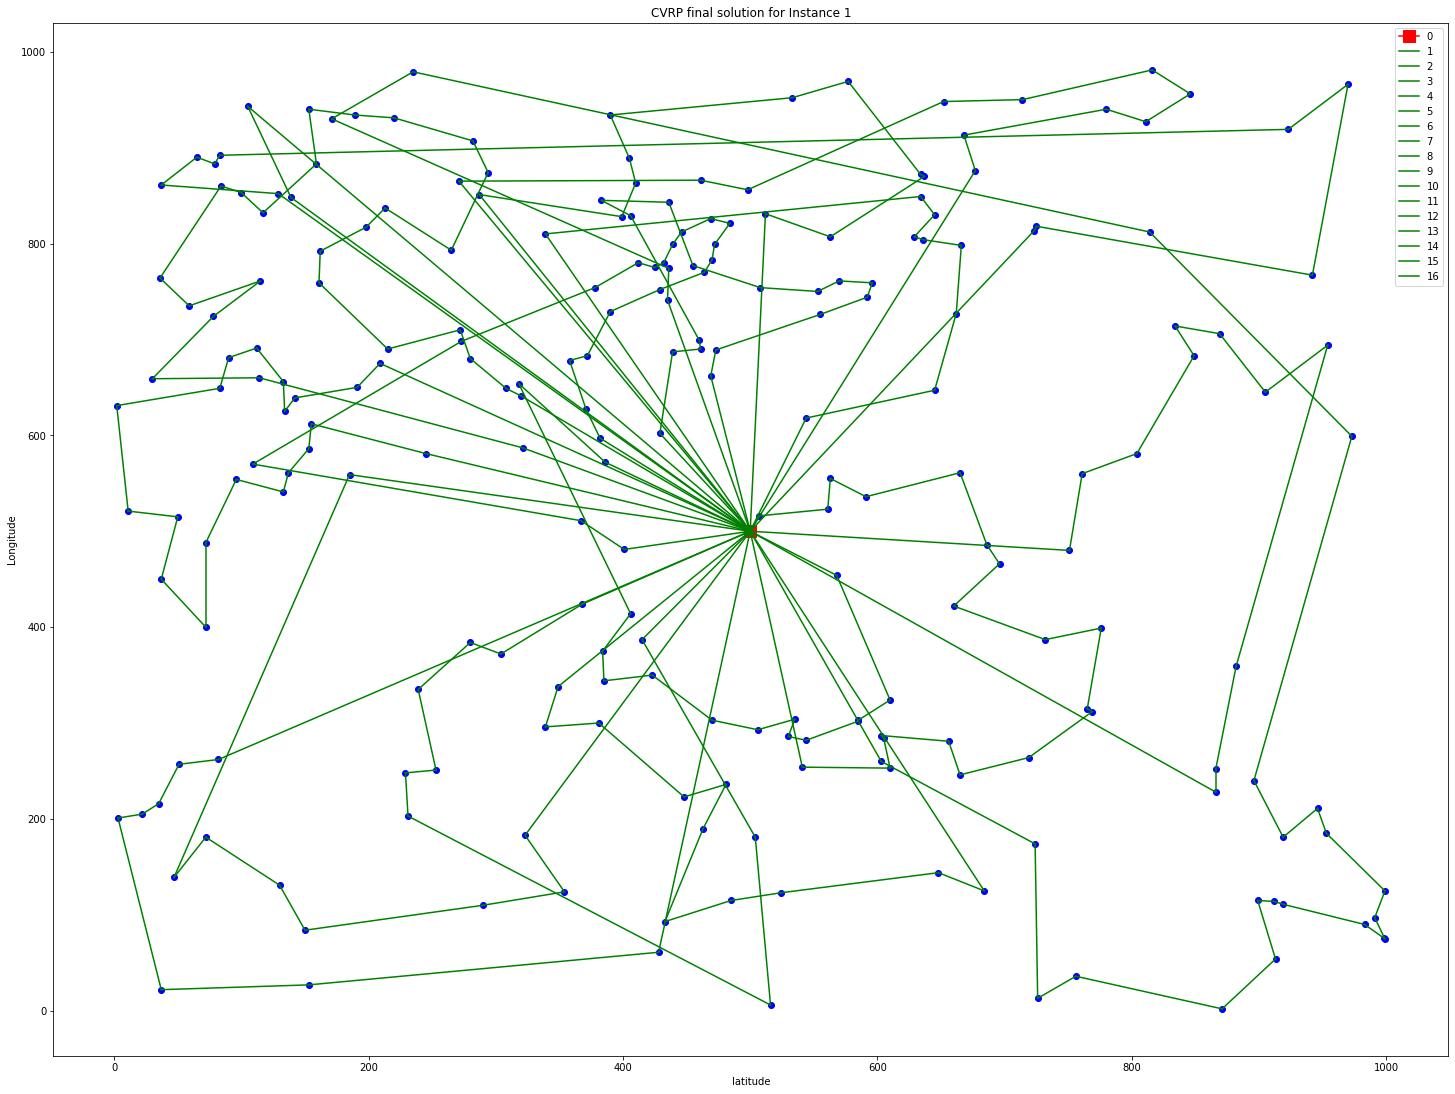

In [53]:
with open ('problem6-3.txt','w') as f:
    f.write('Best so far loss: ' + str(Objective)+'\n' )
    f.writelines('execute time: '+str(cputime)+'\n')
    f.write('The total number of times that the objective function is evaluated: '+str(Ob_fun_Ev)+'\n')
    for row in route.keys():
        f.writelines('Route'+str(row)+': '+str(route[row])+'\n')
    f.write('Gap: '+str(gap)+'%')

df = data_parameters['location']
data_info = data_parameters['data_information']
customer_list = data_parameters['customer_list']
cr = data_parameters['coords']

x_d, y_d, x_c, y_c = coordinates(df, data_info)
arcs = [(i,j) for i in customer_list for j in customer_list if i!=j]

visible_node = active_graph(route, cr)

plt.figure(figsize=(25,19))
groups = [i for i in route.keys()]
ax = plt.subplot(111)
plt.plot(x_d, y_d, 'r',marker ='s', Markersize=12 )
plt.scatter(x_c, y_c,c='b', marker='o')
k=0
for i,j in visible_node:
    plt.plot([df['x'][i], df['x'][j]],[df['y'][i], df['y'][j]],'g')
plt.title("CVRP final solution for Instance 1")
plt.ylabel("Longitude")
plt.xlabel("latitude")
plt.legend(groups)
# plt.savefig('problem_tabu6')

Text(0.5, 0, 'Iteration')

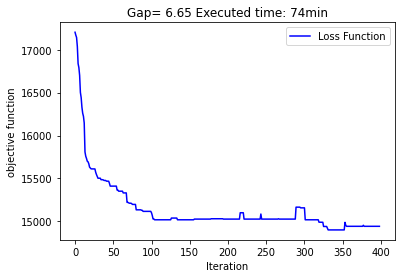

In [28]:
plt.plot(Loss,'b', label='Loss Function')
plt.title('Gap= '+str(round(gap-3,2)) + ' Executed time: '+str(round(cputime-40))+'min')
plt.legend()
plt.ylabel('objective function')
plt.xlabel('Iteration')